In [84]:
# %matplotlib inline

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

samples_dir = Path("data/p4_1/")
# P1, P2_2, P3, P4_1
#movement_2, movement_manual_1, movement_manual_2

MULTILATERATION_METHOD = "2d"

LANG = "PL"

KALMAN = True
SMOOTHE = True
# SMOOTHE = False
SMOOTHING_WINDOW=3

REMOVE_OUTLIERS = True

# These can be overridden by environment.json
MOVEMENT=False
REF_POINT="P1"

# Ignorowanie danych z węzłów stacjonarnych
DEL_ANCHORS = [] # Default
# DEL_ANCHORS = ["0x6c0d"]
# DEL_ANCHORS = ["0x5601"]
# DEL_ANCHORS = ["0x26bd"]
# DEL_ANCHORS = ["0x5836"]

In [86]:
# Ustawienia wykresów
dpi = 600
width_inches = 6
height_inches = width_inches * 3/4 
FONT_SIZE = 12

In [87]:
# Try to get test environment conditions from JSON
import json

try:
    with open(samples_dir / "environment.json", "r") as file:
        settings = json.loads(file.read())
except:
    settings = dict()

if (TAG:=settings.get("tag")) is None:
    from data.points import TAG
if (ANCHORS := settings.get("anchors")) is None:
    from data.points import ANCHORS

In [88]:
class AccelerometerOrientation:
    x_sign: int
    global_x: str
    y_sign: int
    global_y: str

    def __init__(self, setting: str) -> None:
        """
        Module orientation
        The arrow should point the same way as the back of the module (accelerometer's +Z axis)
        <------x-------
               ^       |
              -y       |
                       |
         <+x     -x>   y
                       |
              +y       |
               v       v
        """
        match setting:
            case "+x":
                data = (1, "acc_z", -1, "acc_y")
            case "-x":
                data = (-1, "acc_z", 1, "acc_y")
            case "+y":
                data = (1, "acc_y", 1, "acc_z")
            case "-y":
                data = (-1, "acc_y", -1, "acc_z")
            case _:
                raise ValueError(setting)

        self.x_sign, self.global_x, self.y_sign, self.global_y = data

ACCELEROMETER_ORIENTATION = AccelerometerOrientation(settings.get("acc_orientation") or "-y")

In [89]:
folder_name = samples_dir.name.upper()

if folder_name.startswith("P"): 
    REF_POINT = samples_dir.name.upper()[:2]
else:
    MOVEMENT=True
    REF_POINT = settings.get("REF_POINT") or REF_POINT


filenames = [f for f in samples_dir.iterdir() if f.name.endswith(".csv")] if samples_dir.is_dir() else [samples_dir]
filenames.sort()

In [90]:
# Read data
dfs = [pd.read_csv(f, index_col=0) for f in filenames]
#Remove unwanted anchors
dfs = [df[~df["anchor"].isin(DEL_ANCHORS)] for df in dfs]

In [91]:
# Enforce same number of samples in stationary data
# USeful for testing filters' error in time domain
if not MOVEMENT:
    min_samples = min(len(df) for df in dfs)
    dfs = [df.head(min_samples) for df in dfs]

In [92]:
# Convert timestamp strings to datetime
for df in dfs:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

dfs = [df[df.anchor.isin(ANCHORS.keys())] for df in dfs]

dfs = [df.set_index("timestamp") for df in dfs]

anchors = dfs[0]["anchor"].unique()

# Multilateration

In [93]:
from multilateration.solve import solve

# Multilateration
solved_dfs = [solve(df, ANCHORS, MULTILATERATION_METHOD) for df in dfs]

In [94]:
solved_dfs = [df.merge(solved_df, on="timestamp")[
    [
        "timestamp",
        "acc_x",
        "acc_y",
        "acc_z",
        "x",
        "y",
        "radius",
    ]
] for df, solved_df in zip(dfs, solved_dfs)]

# Convert to metric, remove gravity
for df in solved_dfs:
    df[["x", "y"]] /= 1000
    df[["acc_x", "acc_y", "acc_z"]] *= 9.80665
    df[["acc_x", "acc_y", "acc_z"]] -= df[["acc_x", "acc_y", "acc_z"]].head(5).mean()


In [95]:
# Show data before outlier filtering

# for df in solved_dfs:
#     plt.scatter(df["x"], df["y"])
# plt.axis("equal")
# plt.show()

In [96]:
# Remove outliers
from helper_functions import remove_outliers

# Remove outliers from the DataFrame
if REMOVE_OUTLIERS:
    n_samples_before = sum(len(df) for df in solved_dfs)
    solved_dfs = [remove_outliers(df, ['x', 'y']) for df in solved_dfs]
    n_samples_after = sum(len(df) for df in solved_dfs)
    display(f"Deleted {n_samples_before-n_samples_after} samples. Left {n_samples_after} out of {n_samples_before} samples.")
    display(f"Removed {100*(1-n_samples_after/n_samples_before):.2f}% of samples")

'Deleted 15 samples. Left 3262 out of 3277 samples.'

'Removed 0.46% of samples'

In [97]:
# Show data after removing outliers

# for df in solved_dfs:
#     if MOVEMENT:
#         plt.plot(df["x"], df["y"])
#     else:
#         plt.scatter(df["x"], df["y"])


# if MOVEMENT:
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
# else:
#     plt.scatter(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, color="green")
# plt.axis("equal")
# plt.grid(True)
# plt.show()

## Calculate errors of unfiltered data

In [98]:
from helper_functions import p2p_dist, p2square, point_line_distance

if MOVEMENT and samples_dir == Path("data/movement_manual_1"):
    borders = [
        (1,0,-2.185),
        (1,0,-0.465),
        (0,1,-1.1),
        (0,1,-2.99),
    ]
    calc_dist = lambda x: p2square(x[0],x[1], borders)
elif MOVEMENT:
    # ax + by + c = 0
    a = 1
    b = 0
    c = - TAG[REF_POINT][0] / 1000
    calc_dist = lambda x: point_line_distance(x[0], x[1], a, b, c)
else:
    calc_dist = lambda x: p2p_dist(x[0], x[1], TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000)

for df in solved_dfs:
    df["error"] = df[["x", "y"]].apply(calc_dist, axis=1)
    

# Kalman filter

In [99]:
from kalman import kalman_step


kalman_dfs = []
if KALMAN:
    for df in solved_dfs:
        # dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6
        dt = df["timestamp"].diff().dropna().mean().to_timedelta64().astype('float64')/1e9


        F = np.matrix(
            [[1, 0, dt**2 / 2, 0], [0, 1, 0, dt**2 / 2], [0, 0, 1, 0], [0, 0, 0, 1]]
        )
        H = np.matrix(np.eye(4))

        Q = np.matrix(np.diag([0.0002, 0.0002, 0.0001, 0.0001]))
        if MOVEMENT:
            R = np.matrix(np.eye(4) * 2e-4)
        else:
            R = np.matrix(
                np.diag(
                    [
                        df["x"].std() ** 2,
                        df["y"].std() ** 2,
                        df[ACCELEROMETER_ORIENTATION.global_x].std() ** 2,
                        df[ACCELEROMETER_ORIENTATION.global_y].std() ** 2,
                    ]
                )
            )

        P = np.matrix(np.eye(4)) * 100
        x = np.matrix("0. 0. 0. 0.").T


        # Filter
        filtered = []
        for _, measurement in df[
            [
                "x",
                "y",
                ACCELEROMETER_ORIENTATION.global_x,
                ACCELEROMETER_ORIENTATION.global_y,
            ]
        ].iterrows():
            measurement = measurement.to_list()
            measurement = [
                measurement[0],  # x
                measurement[1],  # y
                ACCELEROMETER_ORIENTATION.x_sign * measurement[2],  # ax
                ACCELEROMETER_ORIENTATION.y_sign * measurement[3],  # ay
            ]
            x, P = kalman_step(x, P, measurement, R, Q, F, H)
            filtered.append(x.tolist())

        filtered_pos = [[x[0], y[0]] for (x, y, _, _) in filtered]
        kalman_dfs.append(pd.DataFrame(filtered_pos, columns=["x", "y"]))
else:
    kalman_dfs = [df[["x","y"]].copy() for df in solved_dfs]

In [100]:
if SMOOTHE:
    kalman_smooth_dfs = [df.copy() for df in kalman_dfs]
    for df in kalman_smooth_dfs:
        df[["x", "y"]] = df[["x", "y"]].rolling(window=SMOOTHING_WINDOW).mean()
        df["error"] = df.apply(calc_dist, axis=1)

for df in kalman_dfs:
    df["error"] = df.apply(calc_dist, axis=1)

In [101]:
# Show errors in time for every CSV, useful for debugging bad measurements

# import plotly.express as px
# import plotly.graph_objects as go

# # for i, df in enumerate(solved_dfs):
# #     plt.plot(df["error"], label=i)
# # plt.legend()
# # plt.show()

# data = {i: df for i, df in enumerate(solved_dfs)}
# fig = go.Figure()

# for i in data:
#     fig = fig.add_trace(go.Line(y = data[i]["error"], 
#                                    name = i))
# fig.show()

# Mean

In [102]:
all_kalman = pd.concat(kalman_dfs, ignore_index=True)
all_uwb = pd.concat(solved_dfs, ignore_index=True)
if SMOOTHE:
    all_smooth = pd.concat(kalman_smooth_dfs, ignore_index=True)

In [103]:
kalman = pd.concat(kalman_dfs)
kalman = kalman.groupby(kalman.index).mean()

solved = pd.concat(solved_dfs)
solved = solved[["x", "y", "error", "timestamp"]]
solved = solved.groupby(solved.index).mean()

if SMOOTHE:
    smooth = pd.concat(kalman_smooth_dfs)
    smooth = smooth.groupby(smooth.index).mean()

In [104]:
def error_over_time_plot(solved, kalman, smooth, solved_dfs, width_inches, height_inches, dpi, suffix="", wide=False):
    x = [i * dt for i in range(len(solved["error"]))]
    x_k = [i * dt for i in range(len(kalman["error"]))]

    plt.rcParams['font.size'] = FONT_SIZE
    plt.plot(x, solved["error"], "--^", label="Bez filtrów", c="tab:orange")
    plt.plot(x_k, kalman["error"], "-o", label="Kalman", c="tab:blue", alpha=0.7)
    if SMOOTHE:
        plt.plot(x_k, smooth["error"], linestyle="dashdot", marker="*", label="Uśredniony Kalman", c="tab:red", alpha=0.5)

    shortest_meas_marker = 30
    if MOVEMENT and len(solved_dfs) > shortest_meas_marker:
        n_of_samples = [len(df) for df in solved_dfs]
        n_of_samples.sort()
        end_of_30th_sample = n_of_samples[shortest_meas_marker]
        plt.axvline(x[end_of_30th_sample], ls="--", c="tab:cyan", label=f"{shortest_meas_marker} shortest measurements" if LANG=="EN" else f"{shortest_meas_marker} najkrótszych\npomiarów")

    legend_loc = "best"
    legend_bbox = None
    legend_cols = 3
    # Custom legend placement
    if not MOVEMENT:
        match REF_POINT:
            case "P1":
                legend_loc = "lower center" if not wide else "upper center"
                legend_bbox = (0.5, 1.01) if not wide else (0.6,0.15)
            case "P2":
                legend_loc = "lower center" if not wide else "upper center"
                legend_bbox = (0.5, 1.01) if not wide else (0.4,1)
            case "P3":
                if not wide:
                    legend_loc = "lower center"
                    legend_bbox = (0.5, 1.01)
            case "P4":
                legend_loc = "lower center"# if not wide else "upper center"
                legend_bbox = (0.5, 1.01)# if not wide else (0.4,1)
                # if wide:
                    # legend_cols = 1

    else:
        legend_cols = 1
    
    plt.gcf().set_size_inches(width_inches, height_inches)
    plt.ylabel("Absolute error [m]" if LANG=="EN" else "Błąd bezwzględny [m]")
    plt.xlabel("Time [s]" if LANG=="EN" else "Czas [s]")
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, fancybox=True, shadow=False, ncol=legend_cols)
    plt.savefig(f"plots_output/errors_over_time_{str(samples_dir).replace('/', '_')}_{REF_POINT}" 
                + (f"_deleted_{'_'.join(DEL_ANCHORS)}" if DEL_ANCHORS else "")
                + suffix
                + ".png",
                dpi=dpi, 
                bbox_inches='tight'
                )
    plt.show()


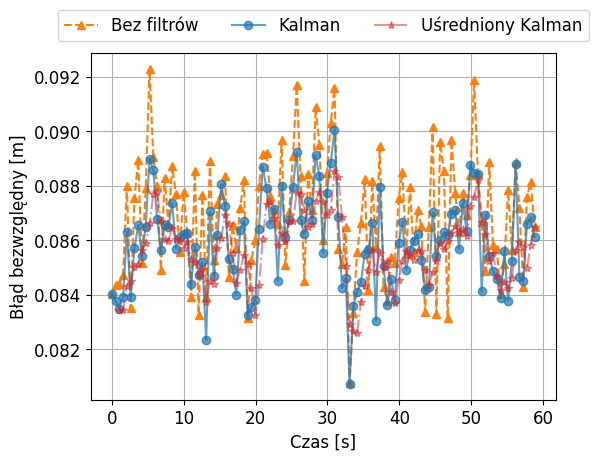

In [105]:
error_over_time_plot(solved, kalman, smooth, solved_dfs, width_inches, height_inches, dpi)

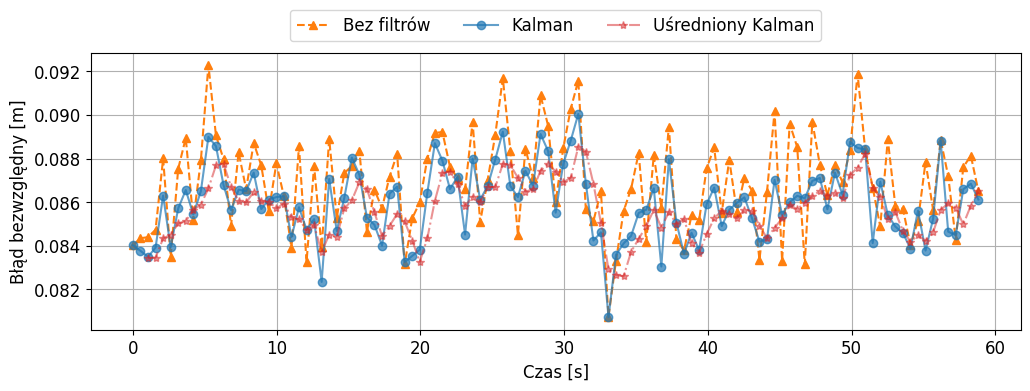

In [106]:
error_over_time_plot(solved, kalman, smooth, solved_dfs, width_inches*2, height_inches*0.8, dpi, "wide", wide=True)

In [107]:
# # Trace/scatter for every data set
# n_plots = 3
# for filename, df, kdf, sdf in zip(filenames[:n_plots], solved_dfs[:n_plots], kalman_dfs[:n_plots], kalman_smooth_dfs[:n_plots]):
#     if MOVEMENT:
#         plt.plot(df.x, df.y, "-", color="tab:orange", label="Bez filtrów")
#         plt.plot(kdf.x, kdf.y, "-", color="tab:blue", label="Kalman", alpha=0.8)
#         if SMOOTHE:
#             plt.plot(sdf.x, sdf.y, "-", color="tab:red", label="Uśredniony Kalman", alpha=0.8)
#         if not samples_dir == Path("data/movement_manual_1/"):
#             plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
#         else:
#             plt.axvline(0.465, color="g", linestyle="--")
#             plt.axvline(2.185, color="g", linestyle="--")
#             plt.axhline(1.1, color="g", linestyle="--")
#             plt.axhline(2.99, color="g", linestyle="--")

#     else:
#         plt.scatter(kdf.x, kdf.y, color="tab:blue", label="Kalman")
#         plt.scatter(df.x, df.y, color="tab:orange" ,label="UWB")
#         if SMOOTHE:
#             plt.scatter(sdf.x, sdf.y, color="tab:red" ,label="Uśredniony Kalman")
#         plt.plot(TAG[REF_POINT][0]/1000, TAG[REF_POINT][1]/1000, "g1")
#     plt.axis("equal")
#     plt.legend(bbox_to_anchor=legend_bbox)
#     print(filename)
#     plt.show()

In [108]:
import seaborn as sns

x_y_comparison_df = pd.concat([all_kalman.copy().assign(name="Kalman"),
                               all_uwb[["x", "y", "error"]].copy().assign(name="UWB"),
                               all_smooth[["x", "y", "error"]].copy().assign(name="Kalman+SMA")])

In [109]:

# # plt.title("Bivariate distribution of positioning results.")
# if MOVEMENT:
#     sns.jointplot(
#         data=x_y_comparison_df,
#         x="x",
#         y="y",
#         hue="name",
#         # kind="kde",
#         # bw_adjust=0.9,
#     )
#     # for df in kalman_dfs:
#     #     plt.plot(df.x, df.y, color="blue")
#     # for df in solved_dfs:
#     #     plt.plot(df.x, df.y, color="orange")
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
# else:    
#     sns.jointplot(
#         data=x_y_comparison_df,
#         x="x",
#         y="y",
#         hue="name",
#         kind="kde",
#         levels=[0.1, 0.3, 0.5, 0.7, 0.9],
#     )
#     plt.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "go")
# ax = plt.gca()
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# ax.get_legend().set_title("")
# plt.grid()
# plt.gcf().set_size_inches(width_inches, width_inches)
# plt.savefig(f"plots_output/kde_{str(samples_dir).replace('/', '_')}_{REF_POINT}.png", dpi=dpi, bbox_inches='tight')
# plt.show()

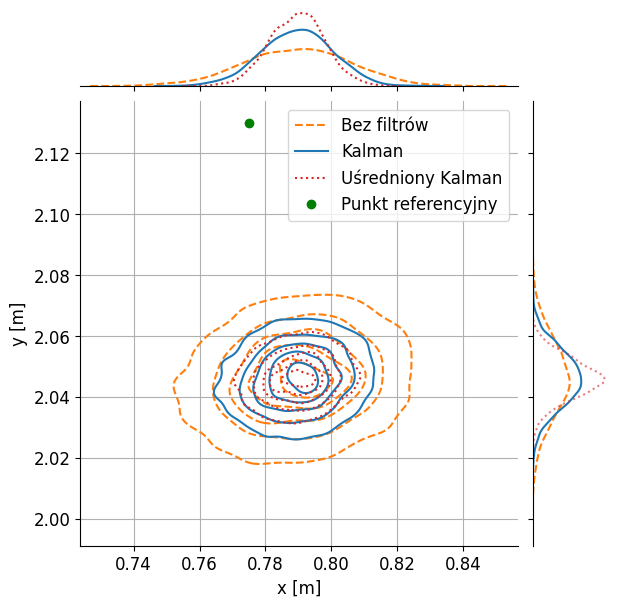

In [110]:
# KDE plot definition

plt.rcParams['font.size'] = FONT_SIZE
g = sns.JointGrid()
if not MOVEMENT:
    # Main plot
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyles="dashed",
            label="UWB",
            ax=g.ax_joint,
            color="tab:orange",
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_joint
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                x="x",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyles="dotted",
                color="tab:red",
                label="Kalman+SMA",
                ax=g.ax_joint
            )
        
    g.ax_joint.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "go")

    # Top marginal (x)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_x
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_marg_x
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                x="x",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyle=":",
                color="tab:red",
                label="Kalman+SMA",
                ax=g.ax_marg_x
            )

    # Right marginal (y)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_y
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            label="Kalman",
            color="tab:blue",
            ax=g.ax_marg_y
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                linestyle=":",
                label="Kalman+SMA",
                color="tab:red",
                alpha=0.6,
                ax=g.ax_marg_y
            )
        
    custom_legend_handles = [plt.Line2D([], [], linestyle='--', color='tab:orange', label='Bez filtrów'),
                        plt.Line2D([], [], linestyle='-', color='tab:blue', label='Kalman'),
                            ]
    if SMOOTHE:
        custom_legend_handles.append(plt.Line2D([], [], linestyle=':', color='tab:red', label='Uśredniony Kalman'))
    custom_legend_handles.append(plt.Line2D([], [], linestyle='None', marker="o", color="g", label="Reference point"  if LANG=="EN" else "Punkt referencyjny"))
else:
    # Main plot
    sns.scatterplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            # linestyles="dashed",
            label="UWB",
            ax=g.ax_joint,
            marker=".",
            color="tab:orange",
            # sort=False,
        )
    sns.scatterplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            alpha=0.8,
            marker="1",
            label="Kalman",
            ax=g.ax_joint,
            # sort=False,
        )
    if SMOOTHE:
        sns.scatterplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                x="x",
                # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                color="tab:red",
                linestyle=":",
                alpha=0.6,
                marker="+",
                label="Kalman+SMA",
                ax=g.ax_joint,
                # sort=False,
            )
    if not samples_dir == Path("data/movement_manual_1/"):
        g.ax_joint.axvline(TAG[REF_POINT][0] / 1000, linestyle="dotted", color="g")
    else:
        g.ax_joint.axvline(0.465, color="g", linestyle="dotted")
        g.ax_joint.axvline(2.185, color="g", linestyle="dotted")
        g.ax_joint.axhline(1.1, color="g", linestyle="dotted")
        g.ax_joint.axhline(2.99, color="g", linestyle="dotted")

    # # Top marginal (x)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_x
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_marg_x
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                x="x",
                # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                color="tab:red",
                label="Kalman+SMA",
                ax=g.ax_marg_x
            )

    # Right marginal (y)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_y
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            label="Kalman",
            color="tab:blue",
            ax=g.ax_marg_y
        )
    if SMOOTHE:
        sns.kdeplot(
                data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman+SMA"],
                y="y",
                # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                label="Kalman+SMA",
                linestyle=":",
                color="tab:red",
                ax=g.ax_marg_y
            )

    custom_legend_handles = [plt.Line2D([], [], linestyle='', marker=".", color='tab:orange', label='Bez filtrów'),
                            plt.Line2D([], [], linestyle='', marker="1", color='tab:blue', label='Kalman'),
                            ]
    if SMOOTHE:
        custom_legend_handles.append(plt.Line2D([], [], linestyle='', marker="+", color='tab:red', label='Uśredniony Kalman'))
    custom_legend_handles.append(plt.Line2D([], [], linestyle='dotted', color="g", label="Reference line"  if LANG=="EN" else "Linia referencyjna"))
custom_legend_labels = [handle.get_label() for handle in custom_legend_handles]

# Add the custom legend to the plot
legend_loc = "best"
legend_bbox = None
legend_columns = 1
# Custom legend placement
match REF_POINT:
    case "P2":
        legend_loc = "center"
        legend_bbox = (0.5,0.6)
if samples_dir == Path("data/movement_manual_1/"):
        legend_bbox = (0.7,0.85)
        g.ax_joint.set_ylim(0.5,4.5)
elif samples_dir == Path("data/movement_2/"):
    match DEL_ANCHORS:
        case ["0x6c0d"]:
            legend_columns = 2
        case ["0x5601"]:
            legend_columns = 2
            legend_loc="upper center"
            legend_bbox= (0.5,1.03)
            

g.ax_joint.legend(handles=custom_legend_handles, labels=custom_legend_labels, loc=legend_loc, bbox_to_anchor=legend_bbox, ncol=legend_columns)
g.ax_joint.set_xlabel("x [m]")
g.ax_joint.set_ylabel("y [m]")
g.ax_joint.grid()
plt.gcf().set_size_inches(width_inches, width_inches)
plt.savefig(f"plots_output/kde_{str(samples_dir).replace('/', '_')}_{REF_POINT}"
            + (f"_deleted_{'_'.join(DEL_ANCHORS)}" if DEL_ANCHORS else "") 
            + ".png"
            , dpi=dpi, bbox_inches='tight')
plt.show()


In [111]:
# Scatter all points in xy
# if MOVEMENT:
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "UWB"]
#     plt.plot(_df["x"], _df["y"], label="UWB")
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"]
#     plt.plot(_df["x"], _df["y"], label="Kalman")
# else:
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "UWB"]
#     plt.scatter(_df["x"], _df["y"], label="UWB")
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"]
#     plt.scatter(_df["x"], _df["y"], label="Kalman")


# if MOVEMENT:
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
# else:
#     plt.scatter(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, color="green")
# plt.axis("equal")
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# plt.legend()
# plt.grid(True)
# plt.show()

# RMSE

In [112]:
# Calculate RMSE
if SMOOTHE:
    errors = pd.concat(
        [all_uwb["error"],all_kalman["error"], all_smooth["error"]],
        axis=1,
        keys=["UWB", "Kalman", "Kalman+SMA"],
    )
else:
    errors = pd.concat(
        [all_uwb["error"],all_kalman["error"]],
        axis=1,
        keys=["UWB", "Kalman"],
    )
rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

display(f"N. of series: {len(filenames)}; N. of samples: {len(all_uwb)}")
for series, value in rmse.items():
    print(f"{series:30}{value*100:.1f}cm")
print()
for series, value in rmse.items():
    percentage = value/rmse['UWB']*100
    change = -(rmse['UWB'] - value) / rmse['UWB']*100
    print(f"{series:30}{percentage:.1f}%\t{change:.1f}%")

'N. of series: 29; N. of samples: 3262'

UWB                           8.8cm
Kalman                        8.6cm
Kalman+SMA                    8.6cm

UWB                           100.0%	-0.0%
Kalman                        98.5%	-1.5%
Kalman+SMA                    97.9%	-2.1%


# Standard deviation of positioning error

In [113]:
# Calculate error std
e_std = errors.std()
for series, value in e_std.items():
    print(f"{series:30}{value*100:.1f}cm")
print()
for series, value in e_std.items():
    percentage = value/e_std['UWB']*100
    change = -(e_std['UWB'] - value) / e_std['UWB']*100
    print(f"{series:30}{percentage:.1f}%\t{change:.1f}%")

UWB                           1.2cm
Kalman                        0.9cm
Kalman+SMA                    0.6cm

UWB                           100.0%	-0.0%
Kalman                        72.2%	-27.8%
Kalman+SMA                    52.8%	-47.2%


# Trajectory slices

In [114]:
# Trace/scatter slices
if MOVEMENT:
    slice_len = 10
    for i in range(slice_len,len(solved), slice_len):
        if MOVEMENT:
            
            plt.plot(solved.x[i-slice_len:i], solved.y[i-slice_len:i], "-^", color="tab:orange", label="Bez filtrów")
            plt.plot(kalman.x[i-slice_len:i], kalman.y[i-slice_len:i], "-o", color="tab:blue", label="Kalman", alpha=0.8)
            if SMOOTHE:
                plt.plot(smooth.x[i-slice_len:i], smooth.y[i-slice_len:i], "-*", color="tab:red", label="Uśredniony Kalman", alpha=0.8)

            if not samples_dir == Path("data/movement_manual_1/"):
                # plt.axvline(TAG[REF_POINT][0] / 1000, linestyle="dotted", color="g")
                pass
            else:
                plt.axvline(0.465, color="g", linestyle="dotted")
                plt.axvline(2.185, color="g", linestyle="dotted")
                plt.axhline(1.1, color="g", linestyle="dotted")
                plt.axhline(2.99, color="g", linestyle="dotted", label="Linia referencyjna")
        else:
            plt.scatter(kalman.x[i-slice_len:i], kalman.y[i-slice_len:i], color="tab:blue", label="Kalman")
            plt.scatter(solved.x[i-slice_len:i], solved.y[i-slice_len:i], color="tab:orange" ,label="Bez filtrów")
            if SMOOTHE:
                plt.scatter(smooth.x[i-slice_len:i], smooth.y[i-slice_len:i], color="tab:red" ,label="Uśredniony Kalman")
            plt.plot(TAG[REF_POINT][0]/1000, TAG[REF_POINT][1]/1000, "g1")
        # plt.axis("equal")
        plt.grid(True)
        plt.legend()
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        print(i-slice_len, i)
        plt.show()